In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from classifier import GPT2ForSequenceClassification #needed as HF can't calculate sequence length from embeds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentiment_model = GPT2ForSequenceClassification.from_pretrained("../models/checkpoint-15000").to(device)
gpt2_model = GPT2LMHeadModel.from_pretrained("../models/checkpoint-35000").to(device)
gpt2_model_ref = GPT2LMHeadModel.from_pretrained("../models/checkpoint-35000").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sentiment_model.config.pad_token_id = tokenizer.eos_token_id
gpt2_model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [13]:
def get_logprobs(combined, batch_size, response_len = 32):
    
    logprobs_tensor, ref_logprobs_tensor = [], []
    for i in range(int(combined.size(0)/batch_size)):
        
        response = combined[i*batch_size:(i+1)*batch_size]
        with torch.no_grad():
            ref_outputs = gpt2_model_ref(input_ids = response)
        outputs = gpt2_model(input_ids = response)

        # Not ideal to re-run this but afaik you can't get logits from model.generate
        logprobs = logprobs_from_logits(outputs['logits'][:,:-1,:], 
                                        response[:,1:])[:, -response_len:]
        
        ref_logprobs = logprobs_from_logits(ref_outputs['logits'][:,:-1,:], 
                                            response[:,1:])[:, -response_len:]
        
        logprobs_tensor.append(logprobs)
        ref_logprobs_tensor.append(ref_logprobs)
        
    return (torch.cat(logprobs_tensor), 
            torch.cat(ref_logprobs_tensor))

def query_model(query, batch_size, response_len = 32):    
    response_tensors = []
    tensor_shape = query['input_ids'].size(0)
    for i in range(int(tensor_shape/batch_size)):
        with torch.no_grad():
            generation_output = gpt2_model.generate(input_ids=query['input_ids'][i*batch_size:(i+1)*batch_size],
                                                    attention_mask=query['attention_mask'][i*batch_size:(i+1)*batch_size],
                                                    max_length=query['attention_mask'].size(1)+response_len, 
                                                    do_sample=False, 
                                                    top_p = 1.0,)
        for tensor in generation_output:
            response_tensors.append(tensor)
    
    torch.cuda.empty_cache()
    #return tokenizer.pad(response_tensors)
    return tokenizer.pad({'input_ids': response_tensors}, 
                         padding=True)['input_ids'].to(device)

def shift_left(inputs):
    #Move non <|endoftext|> to the beginning
    input_ids = torch.full_like(inputs, 50256)
    attention_mask = torch.zeros_like(inputs)
    ne = torch.ne(inputs, 50256)
    
    for i in range(ne.shape[0]):
        input_ids[i, :ne[i].sum(-1)] = inputs[i,ne[i]]
        attention_mask[i, :ne[i].sum(-1)] = 1
    
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

def logprobs_from_logits(logits, labels):
    """
    See: https://github.com/pytorch/pytorch/issues/563#issuecomment-330103591
    """
    logp = F.log_softmax(logits, dim=2)
    return torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)

In [3]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        return torch.nn.functional.one_hot(inputs.argmax(dim=2), num_classes = inputs.shape[2]).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class LogitsToEmbeds(nn.Module):
    def __init__(self, embedding_weight):
        super(LogitsToEmbeds, self).__init__()
        
        self.fake_embedding = nn.Linear(embedding_weight.weight.size(0), embedding_weight.weight.size(1), bias = False)
        self.fake_embedding.weight = torch.nn.Parameter(embedding_weight.weight.t())
        self.softmax = nn.Softmax(dim = 2)
        
    def forward(self, x):
        x = self.softmax(x)
        x = STEFunction.apply(x)
        x = self.fake_embedding(x)
        return x

sentiment_wte = sentiment_model.get_input_embeddings()
    
l2e = LogitsToEmbeds(sentiment_wte)

In [14]:
from datasets import load_dataset
from tqdm import tqdm

datasets = load_dataset("json", field='data', data_files={
    "train": "../data/tldr-filtered-test.json",
    "validation": "../data/tldr-filtered-test.json"
})

# prep dataset
def tokenize_function(examples):
    output = tokenizer([txt + ' TLDR:' for txt in examples['content']], max_length=512, truncation=True, padding=True)
    return output

tokenized_datasets = datasets.map(
    tokenize_function,
    batched=True,
    num_proc=1,
    remove_columns = datasets["train"].column_names
)

def collate_wrapper(batch):
    return tokenizer.pad(batch, return_tensors='pt')

from torch.utils.data import DataLoader

loader = DataLoader(tokenized_datasets['train'], batch_size=1, pin_memory=False, collate_fn=collate_wrapper)

Using custom data configuration default
Reusing dataset json (/home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514)
Loading cached processed dataset at /home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-8aa975390cef55cc.arrow
Loading cached processed dataset at /home/kip/.cache/huggingface/datasets/json/default-a8082db3ce507167/0.0.0/70d89ed4db1394f028c651589fcab6d6b28dddcabbe39d3b21b4d41f9a708514/cache-8b8ab68d34416716.arrow


In [15]:
def logprobs_from_logits(logits, labels):
    """
    See: https://github.com/pytorch/pytorch/issues/563#issuecomment-330103591
    """
    logp = F.log_softmax(logits, dim=2)
    return torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)

out = []
lens = []
kls = []
combined = []

response_len = 64
optimizer = torch.optim.Adam(gpt2_model.parameters(), lr=4e-5)

sentiment_wte = sentiment_model.get_input_embeddings()
fake_embedding = nn.Linear(sentiment_wte.weight.size(0), sentiment_wte.weight.size(1), bias = False)
fake_embedding.weight = torch.nn.Parameter(sentiment_wte.weight.t())


optimizer.zero_grad()
for idx, batch in enumerate(tqdm(loader)):
    batch = batch.to(device)
    generation_output = gpt2_model.generate(input_ids=batch['input_ids'],
                                            attention_mask=batch['attention_mask'],
                                            max_length=batch['attention_mask'].size(1)+response_len)
                                            #do_sample=True, 
                                            #top_p = 1.0,)
    
    outputs = gpt2_model(input_ids=generation_output)
    logits = outputs['logits'][:,:-1,:][:, batch['input_ids'].shape[1]-1:]
    logits = F.gumbel_softmax(logits, tau=1, hard=True, dim=2)
    response_embeds = fake_embedding(logits)
    
    ref_logits = gpt2_model_ref(input_ids = generation_output)['logits']

    logprobs = logprobs_from_logits(outputs['logits'], 
                                    generation_output[:,1:])[:, -response_len:]

    ref_logprobs = logprobs_from_logits(ref_logits[:,:-1,:], 
                                        generation_output[:,1:])[:, -response_len:]
    
    #Straight through estimator
    #response_embeds = l2e(logits)
    
    
    query_embeds = sentiment_wte.weight[batch['input_ids']]

    embeds = torch.cat([query_embeds,response_embeds],dim=1)

    lengths = torch.ne(generation_output, 50256).sum(-1)
    
    input_embeds = sentiment_wte.weight[50256].repeat(embeds.shape[0],embeds.shape[1],1)
    ne = torch.ne(generation_output, 50256)

    for i in range(ne.shape[0]):
        #rint(ne[i].sum(-1))
        input_embeds[i, :ne[i].sum(-1)] = embeds[i,ne[i]]

    #Need to do a final shift here
    score = sentiment_model(inputs_embeds = input_embeds, sequence_lengths = lengths-1)['logits']
    
    #optimizer.zero_grad()
    kl = logprobs-ref_logprobs
    kls.append(kl.mean())
    loss = (-score + 0.3 * kl.mean()).mean()
    loss.backward()
    
    #optimizer.step()
    if (idx+1)%128 == 0: 
        optimizer.step()
        optimizer.zero_grad()
    
    combined.append(loss.item())
    out.append(score.mean().item())
    lens.append(ne.sum(-1).float().mean())

  2%|▏         | 758/40396 [08:44<7:36:49,  1.45it/s]


KeyboardInterrupt: 

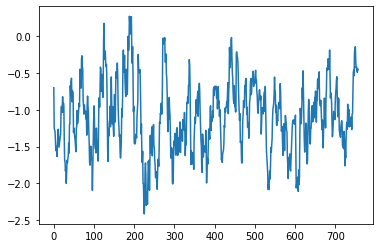

In [21]:
import matplotlib.pyplot as plt
plt.plot(smooth(out,10))

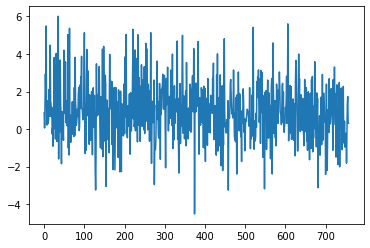

In [20]:
plt.plot(combined)

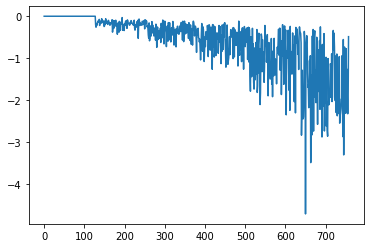

In [19]:
plt.plot(kls)

In [12]:
-(logprobs-ref_logprobs) == (ref_logprobs-logprobs)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]], device='cuda:0')

In [21]:
tokenizer.decode(generation_output[0])

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [13]:
for p in gpt2_model.parameters():
    print(p)
    break

Parameter containing:
tensor([[-1.0461e-01, -4.6146e-02,  2.8925e-02,  ..., -1.3889e-01,
          1.2715e-02,  3.2415e-02],
        [ 3.3557e-02, -4.7043e-02,  4.2919e-02,  ...,  9.4915e-02,
         -2.8106e-05,  3.2102e-02],
        [-1.0857e-01,  3.3453e-02,  2.1194e-01,  ...,  8.8216e-02,
         -1.2232e-01, -1.1091e-01],
        ...,
        [-4.5509e-02, -7.5638e-02,  2.1860e-02,  ...,  1.2654e-01,
          7.1388e-02, -6.9881e-02],
        [ 1.6959e-01,  1.6698e-02,  4.7404e-02,  ..., -9.1004e-02,
          7.4290e-02, -2.8124e-02],
        [-2.6943e-02,  2.5848e-02,  5.6521e-02,  ...,  1.0012e-01,
          1.4970e-01,  1.2503e-02]], device='cuda:0', requires_grad=True)


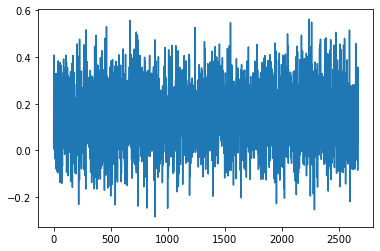

In [9]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        return torch.nn.functional.one_hot(inputs.argmax(dim=2), num_classes = inputs.shape[2]).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class LogitsToEmbeds(nn.Module):
    def __init__(self, embedding_weight):
        super(LogitsToEmbeds, self).__init__()
        
        self.fake_embedding = nn.Linear(embedding_weight.weight.size(0), embedding_weight.weight.size(1), bias = False)
        self.fake_embedding.weight = torch.nn.Parameter(embedding_weight.weight.t())
        self.softmax = nn.Softmax(dim = 2)
        
    def forward(self, x):
        x = self.softmax(x)
        x = STEFunction.apply(x)
        x = self.fake_embedding(x)
        return x

sentiment_wte = sentiment_model.get_input_embeddings()
    
l2e = LogitsToEmbeds(sentiment_wte)

In [17]:
query_embeds.shape

torch.Size([2, 6, 768])

In [10]:
generation_output.shape

torch.Size([4, 268])

In [70]:
generation_output.shape

torch.Size([2, 18])

In [175]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs):
        return torch.nn.functional.one_hot(inputs.argmax(dim=2), num_classes = inputs.shape[2]).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

    
class LogitsToEmbeds(nn.Module):
    def __init__(self, embedding_weight):
        super(LogitsToEmbeds, self).__init__()
        
        self.fake_embedding = nn.Linear(embedding_weight.weight.size(0), embedding_weight.weight.size(1), bias = False)
        self.fake_embedding.weight = torch.nn.Parameter(embedding_weight.weight.t())
        self.softmax = nn.Softmax(dim = 2)
        
    def forward(self, x):
        x = self.softmax(x)
        x = STEFunction.apply(x)
        x = self.fake_embedding(x)
        return x

class PreferenceLearner(nn.Module):
    def __init__(self, base, reference, reward):
        super(PreferenceLearner, self).__init__()
        self.model = base
        self.ref = reference
        self.reward = reward
        self.toEmbeds = LogitsToEmbeds(sentiment_model.get_input_embeddings())
        
    def logprobs_from_logits(self, logits, labels):
        logp = F.log_softmax(logits, dim=2)
        return torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    
    def get_score(self, generation_output, eot_token = 50256):
        #Move non <|endoftext|> to the beginning
            
        score = self.reward(inputs_embeds = input_ids) 
        
    def forward(self, input_ids, attention_mask, length):
        
        ref_logits = self.ref(input_ids=input_ids, 
                              attention_mask=attention_mask)['logits']
        logits = self.model(input_ids=input_ids, 
                            attention_mask=attention_mask)['logits']
        
        ref_logprobs = self.logprobs_from_logits(ref_logits, input_ids)
        logprobs = self.logprobs_from_logits(logits, input_ids)
        
        kl = logprobs - ref_logprobs
        
        embeds = self.toEmbeds(logits)
        
        score = self.reward(inputs_embeds = embeds, 
                            sequence_lengths = length-1)['logits']
        
        return score, kl.mean(1)
    
        
    
model = PreferenceLearner(gpt2_model, 
                          gpt2_model_ref, 
                          sentiment_model)

In [8]:
#Move non <|endoftext|> to the beginning
input_ids = torch.full_like(generation_output, 50256)
attention_mask = torch.zeros_like(generation_output)
ne = torch.ne(generation_output, 50256)
for i in range(ne.shape[0]):
    empty[i, :ne[i].sum(-1)] = generation_output[i,ne[i]]
    attention_mask[i, :ne[i].sum(-1)] = 1

NameError: name 'empty' is not defined

In [6]:
def query_model(query, batch_size, response_len = 32):    
    response_tensors = []
    tensor_shape = query['input_ids'].size(0)
    for i in range(int(tensor_shape/batch_size)):
        with torch.no_grad():
            generation_output = gpt2_model.generate(input_ids=query['input_ids'][i*batch_size:(i+1)*batch_size],
                                                    attention_mask=query['attention_mask'][i*batch_size:(i+1)*batch_size],
                                                    max_length=query['attention_mask'].size(1)+response_len, 
                                                    do_sample=True, 
                                                    top_p = 1.0,)
        for tensor in generation_output:
            response_tensors.append(tensor)
    
    torch.cuda.empty_cache()
    #return tokenizer.pad(response_tensors)
    return tokenizer.pad({'input_ids': response_tensors}, 
                         padding=True)['input_ids'].to(device)

query_model(inputs, 2, 32).backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [8]:
512/512

1.0